### Preliminary Analysis

In [1]:
import pandas as pd
import string

In [6]:
cases_text = pd.read_csv("/Users/iphonex/Downloads/Court-Cases-Text-Analytics/Ontario-Court-Cases/data/courtlistener_cases.csv")
cases_meta = pd.read_json('data/courtlistener_cases.json')

In [7]:
# Check first rows
print("Text CSV columns:", cases_text.columns)
print("Metadata JSON columns:", cases_meta.columns)

Text CSV columns: Index(['docket_id', 'docket_number', 'case_name', 'court_id', 'date_filed',
       'date_terminated', 'nature_of_suit', 'cause', 'jurisdiction_type',
       'cluster_id', 'cluster_date_filed', 'cluster_case_name', 'judges',
       'panel_str', 'citation_count', 'opinion_id', 'opinion_type',
       'author_str', 'opinion_text_html', 'opinion_text_plain', 'download_url',
       'opinions_cited_count', 'absolute_url', 'cluster_url'],
      dtype='str')
Metadata JSON columns: Index(['docket_id', 'docket_number', 'case_name', 'court_id', 'date_filed',
       'date_terminated', 'nature_of_suit', 'cause', 'jurisdiction_type',
       'cluster_id', 'cluster_date_filed', 'cluster_case_name', 'judges',
       'panel_str', 'citation_count', 'opinion_id', 'opinion_type',
       'author_str', 'opinion_text_html', 'opinion_text_plain', 'download_url',
       'opinions_cited_count', 'absolute_url', 'cluster_url'],
      dtype='str')


In [ ]:
#Data Cleaning pipeline

import re
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# ---- Legal stopwords ----
legal_stopwords = set([
    "court", "plaintiff", "defendant", "opinion", "slip", "term", "filed", "judge"
])

# ---- Combined cleaning function ----
def clean_case_text(text):
    text = str(text)

    # Remove boilerplate
    boilerplate_patterns = [
        r'october syllabus note.*?v\. ',    # until first 'v.' (case name)
        r'preliminary print.*?supreme',     # preliminary print notices
        r'cite u s .*',                      # citation lines
        r'supreme united states.*?v\. '      # repeated "supreme united states v."
    ]
    for pat in boilerplate_patterns:
        text = re.sub(pat, '', text, flags=re.IGNORECASE|re.DOTALL)

    # Standard cleaning
    text = text.lower()                   # lowercase
    text = re.sub(r'\d+', '', text)       # remove numbers
    text = re.sub(r'\s+', ' ', text)      # collapse whitespace
    text = re.sub(r'[^\w\s]', '', text)   # remove punctuation
    tokens = text.split()
    tokens = [t for t in tokens if t not in ENGLISH_STOP_WORDS and t not in legal_stopwords]
    
    # Remove single letters left (like 's', 'v', 'u')
    tokens = [t for t in tokens if len(t) > 1]

    return " ".join(tokens)

# ---- Apply cleaning ----
cases_text['clean_text'] = cases_text['opinion_text_plain'].apply(clean_case_text)

# ---- Remove empty docs ----
cases_text = cases_text[cases_text['clean_text'].str.strip() != ""]

# ---- Count word frequencies ----
all_words = " ".join(cases_text['clean_text']).split()
word_counts_filtered = Counter(all_words)

# ---- Show top 20 words to check cleanliness----
print("Top 20 words across all cases (filtered):")
print(word_counts_filtered.most_common(20))


Top 20 words across all cases (filtered):
[('states', 9406), ('courts', 7933), ('united', 7409), ('id', 6129), ('law', 6117), ('federal', 5550), ('state', 4927), ('case', 4649), ('does', 4557), ('dissenting', 4354), ('government', 4348), ('rule', 4321), ('congress', 4209), ('cite', 4053), ('act', 3923), ('district', 3764), ('pending', 3576), ('order', 3421), ('publication', 3384), ('proof', 3383)]


In [64]:
#Remove html

from bs4 import BeautifulSoup

# Function to strip HTML
def strip_html(text):
    if not text or pd.isna(text):
        return ""
    return BeautifulSoup(text, "html.parser").get_text(separator=" ")

# Apply to your column
cases_text['clean_text'] = cases_text['clean_text'].apply(strip_html)


In [ ]:
#Text Statistics

# ---- DATE SPAN ----
if 'cluster_date_filed' in cases_meta.columns:
    cases_meta['cluster_date_filed'] = pd.to_datetime(cases_meta['cluster_date_filed'], errors='coerce')
    print("\nCases span from", cases_meta['cluster_date_filed'].min().date(),
          "to", cases_meta['cluster_date_filed'].max().date())

# ---- JURISDICTION ----
if 'jurisdiction' in cases_meta.columns:
    print("\nJurisdictions covered:")
    print(cases_meta['jurisdiction'].value_counts())

# ---- TOTAL NUMBER OF JUDGES ----
if 'judges' in cases_meta.columns:
    all_judges = set()
    for j in cases_meta['judges']:
        if pd.isna(j):
            continue
        try:
          
            judges_list = ast.literal_eval(j) if isinstance(j, str) else j
            all_judges.update(judges_list)
        except:
            all_judges.add(j)  
    print("\nTotal unique judges across all cases:", len(all_judges))



Cases span from 2024-04-15 to 2026-01-26

Total unique judges across all cases: 10


In [ ]:
#Cases per court

print("Cases per court:")
print(cases_text['court_id'].value_counts())


Cases per court:
court_id
scotus    274
Name: count, dtype: int64


In [ ]:
#Judges statistics

from collections import Counter

all_judges = []
for j in cases_text['judges']:
    if pd.isna(j):
        continue
    try:
        all_judges.extend(ast.literal_eval(j) if isinstance(j, str) else [j])
    except:
        all_judges.append(j)

print("Top 10 most frequent judges:")
print(Counter(all_judges).most_common(10))



Top 10 most frequent judges:
[('Sonia Sotomayor', 44), ('Per Curiam', 33), ('Clarence Thomas', 33), ('Samuel Alito', 31), ('Neil Gorsuch', 29), ('Ketanji Brown Jackson', 23), ('Brett Kavanaugh', 22), ('Amy Coney Barrett', 21), ('Elana Kagan', 20), ('John G. Roberts', 18)]


In [ ]:
#Cases filings over the years

cases_text['cluster_date_filed'] = pd.to_datetime(cases_text['cluster_date_filed'], errors='coerce')
cases_text['year'] = cases_text['cluster_date_filed'].dt.year
print("Cases per year:")
print(cases_text['year'].value_counts().sort_index())


Cases per year:
year
2024     62
2025    201
2026     11
Name: count, dtype: int64


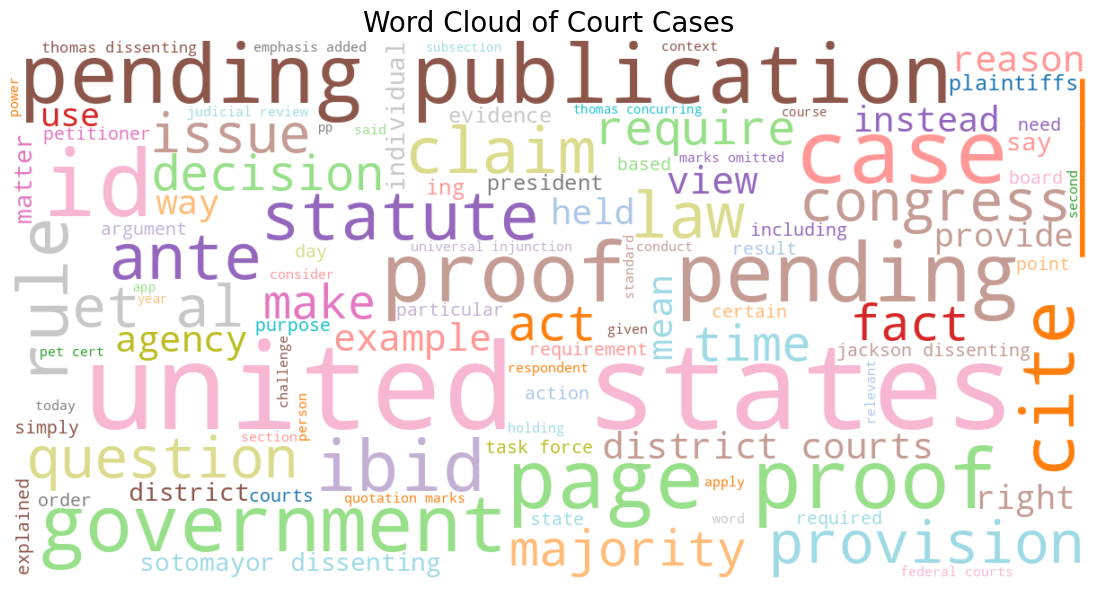

In [61]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all cleaned text
text_combined = " ".join(cases_text['clean_text'])

# Create the WordCloud
wordcloud = WordCloud(
    width=1200,
    height=600,
    background_color='white',
    max_words=100,
    colormap='tab20'
).generate(text_combined)

# Plot
plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Court Cases", fontsize=20)
plt.show()
